# Previsão de risco de inadimplência - HBSIS

![title](media/fraudes.jpg)
## Descrição do problema
O seguinte puzzle foi posto:

>**The problem:**
>
>As a credit company, it is important to know beforehand who is able to pay their loans and who is not.
>
>**The goal of this puzzle:**
>
>* Build a statistical/machine learning model to figure out which clients are able to honor their debt. (Criar um modelo para prever 'default')
>* Predict the probability of 'default', which is identified by the default variable in the training dataset. (Avaliar os resultados da modelagem)

Este notebook tem como objetivo atender aos objetivo acima, apoiado com AutoML.

## Entendimento e visualização dos dados

Inicialmente, importamos e visualizamos a forma do Dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', 60 )
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 20)

df = pd.read_csv('puzzle_train_dataset.csv')
df.head(2)

ids default              score_1              score_2  \
0  810e3277-619e-31...   False  smzX0nxh5QlePvtV...  tHpS8e9F8d9zg3iO...   
1  b4118fd5-77d5-4d...   False  DGCQep2AE5QRkNCs...  RO7MTL+j4PH2gNzb...   

   score_3     score_4   score_5     score_6  risk_rate  amount_borrowed  \
0    710.0  104.174961  0.661509  123.015325       0.43         20024.31   
1    330.0   97.880798  0.531115  110.913484       0.23         10046.51   

   borrowed_in_months  credit_limit               reason    income  sign  \
0                60.0       62386.0  mLVIVxoGY7TUDJ1F...  59869.05  virg   
1                36.0           NaN  mLVIVxoGY7TUDJ1F...  46016.31  sagi   

  gender facebook_profile                state                  zip  \
0      f             True  xsd3ZdsI3356I3xM...  i036nmJ7rfxo+3Ev...   
1      f            False  xsd3ZdsI3356I3xM...  oyrt7nHjoQSc58vC...   

               channel             job_name           real_state  ok_since  \
0  NCqL3QBx0pscDnx3...  mLVIVxoGY7TUDJ1F...  n+xK9CfX0bCn77lC...      14.0   
1  NCqL3QBx0pscDnx3...  mLVIVxoGY7TUDJ1F...  n+xK9CfX0bCn77lC...      75.0   

   n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  
0             1.0                0.0         9.0       9.0  
1             0.0                0.0         3.0       NaN

Como o AutoML automatiza rotinas de modelagem, a visualização automática (AutoViz, por exemplo) automatiza a plotagem.
É uma ferramenta limitada, mas que cumpre boa função quando se deseja uma rápida visualização. Com apenas uma única linha de códico, o AutoViz analisa o conjunto de dados e introduz plots que considera relevantes ao levar em consideração os tipos de variaveis, variavel alvo, número de colunas, etc.

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'
Shape of your Data Set: (64592, 25)
Classifying variables in data set...
    Number of Numeric Columns =  9
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  8
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  2
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  2
    Number of NLP String Columns =  2
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    24 Predictors classified...
        This does not include the Target column(s)
    4 variables

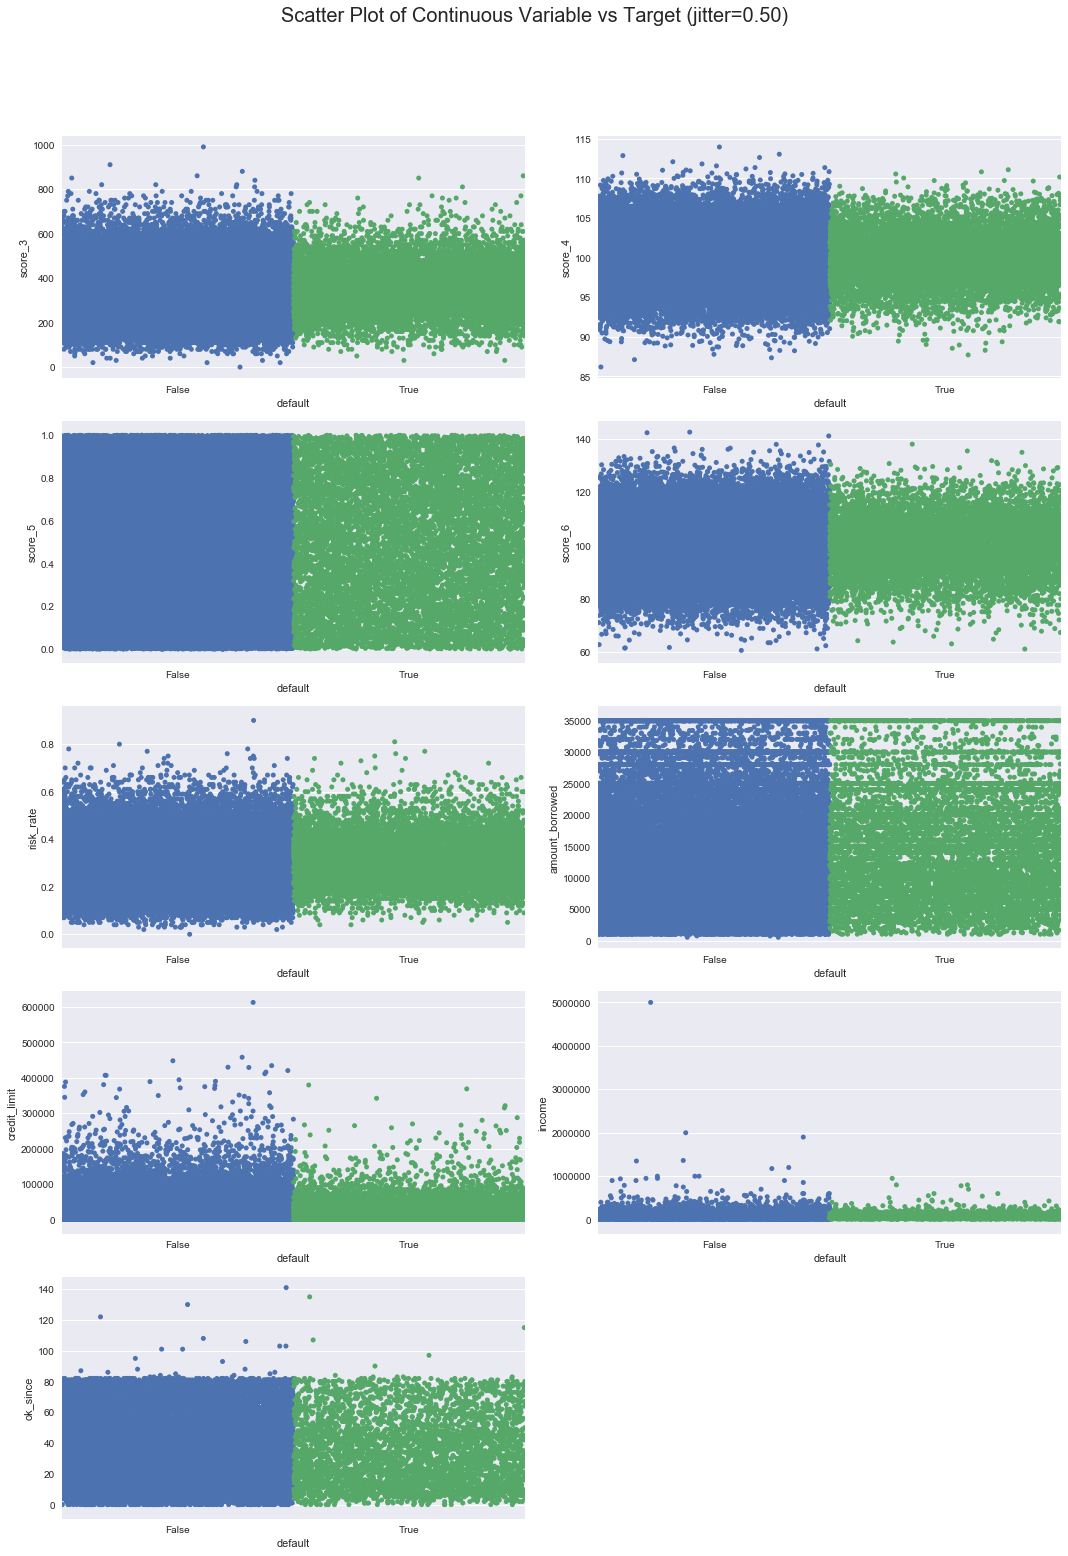

Total Number of Scatter Plots = 45


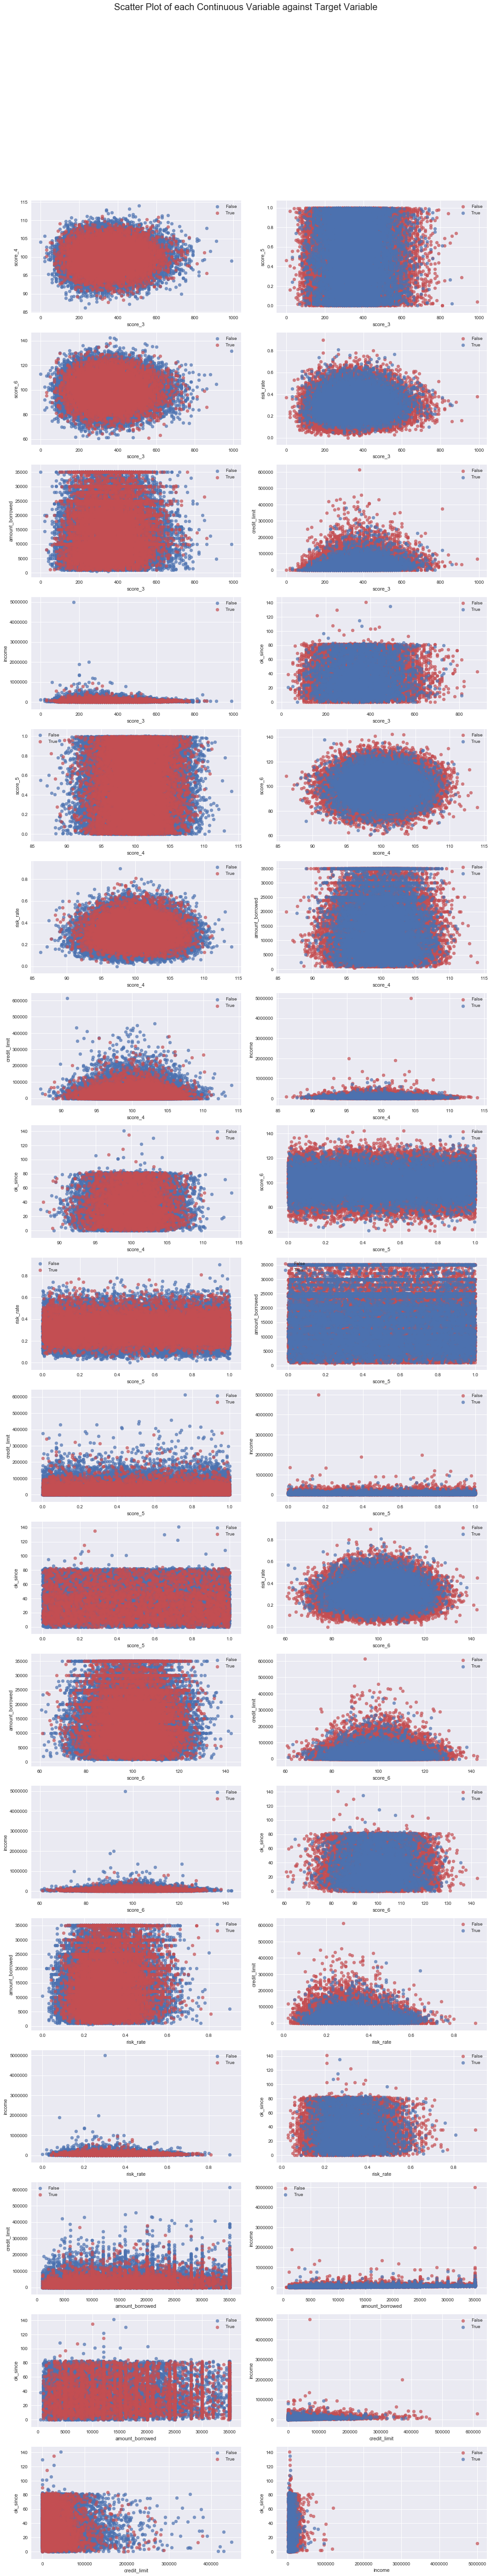

Could not draw Distribution Plots


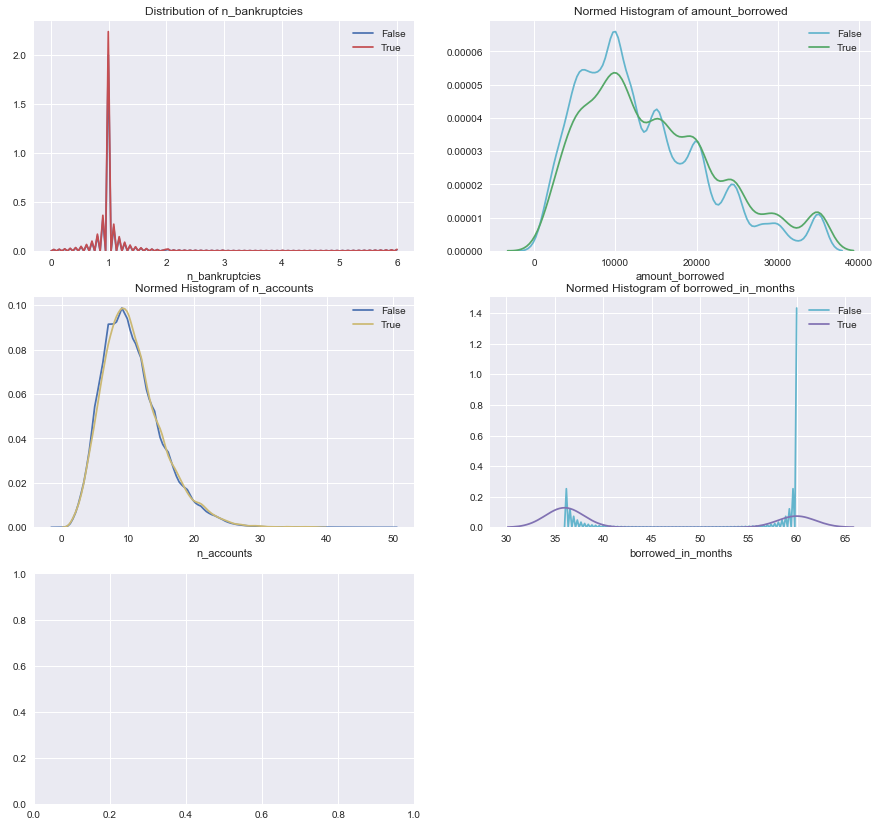

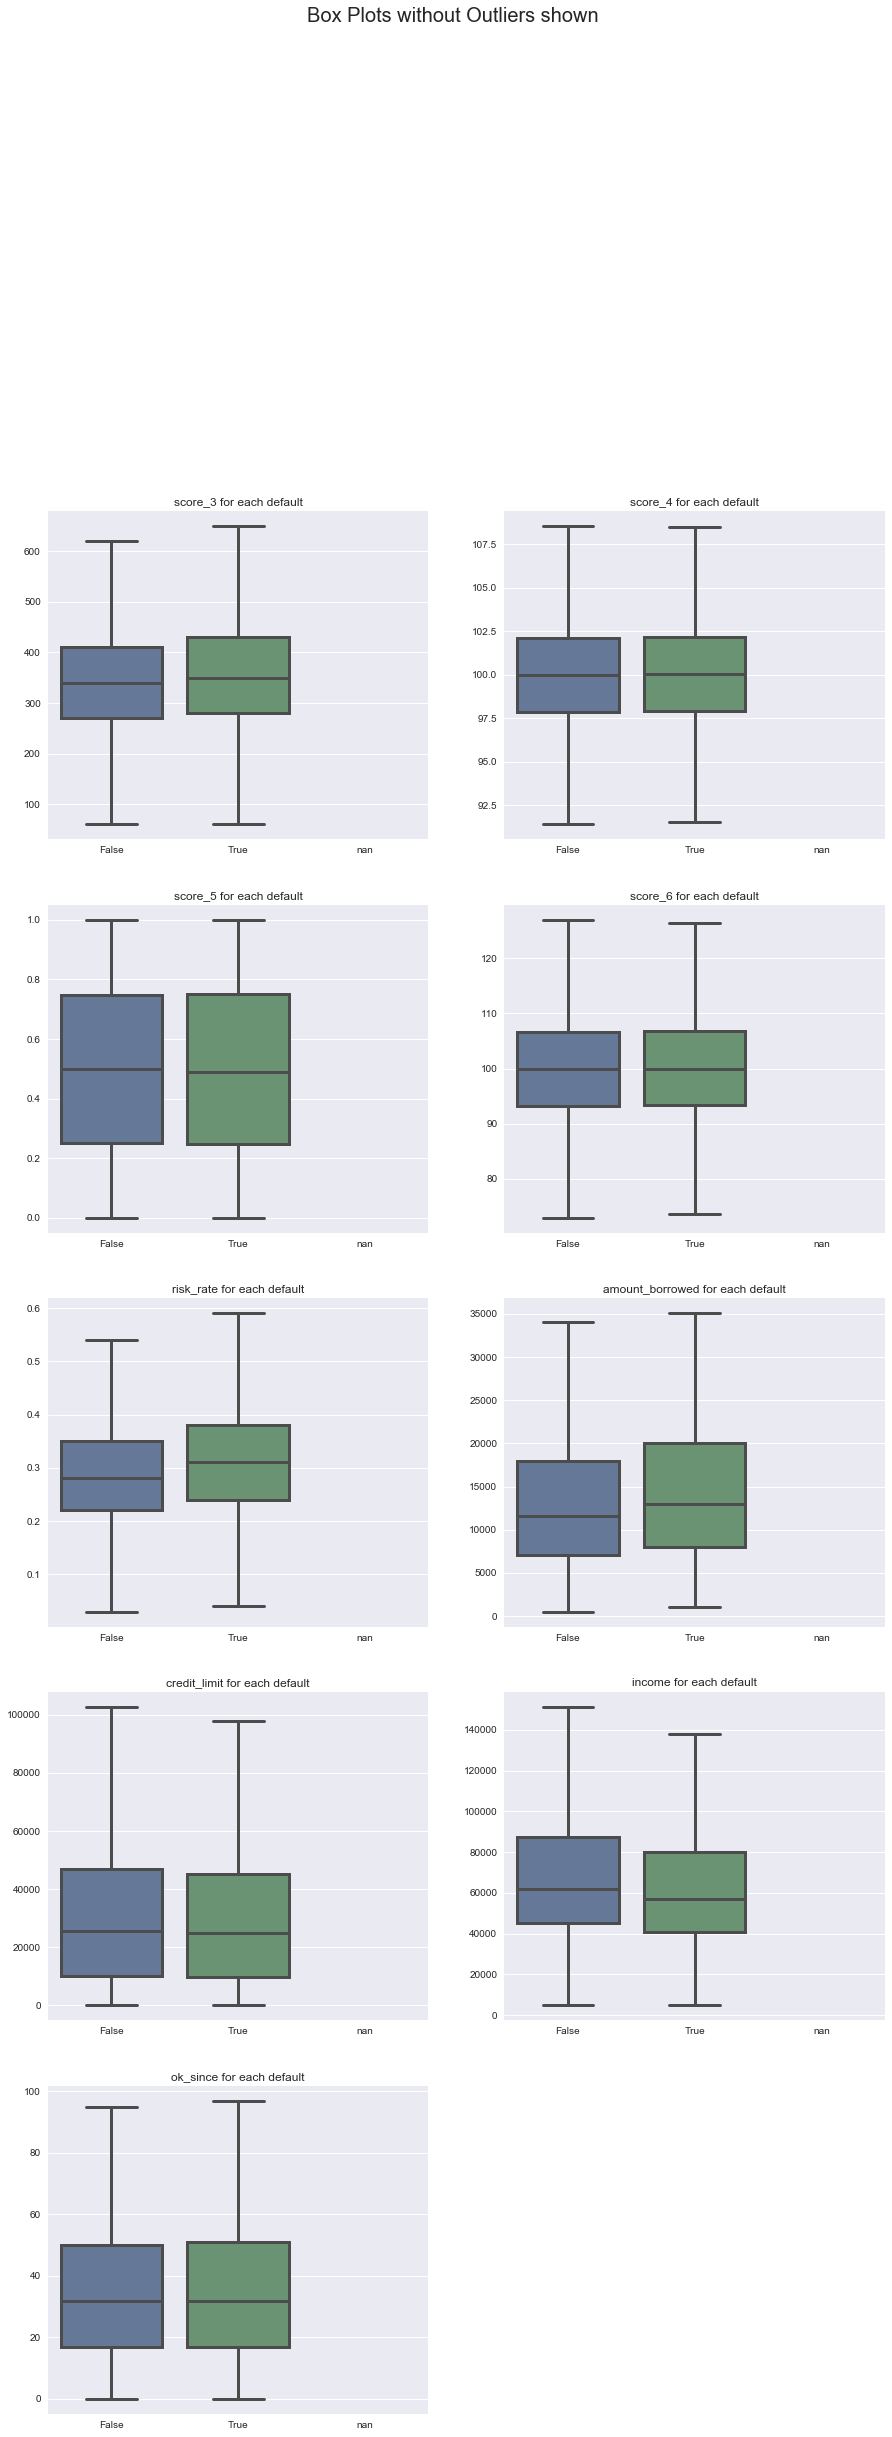

No date vars could be found in data set


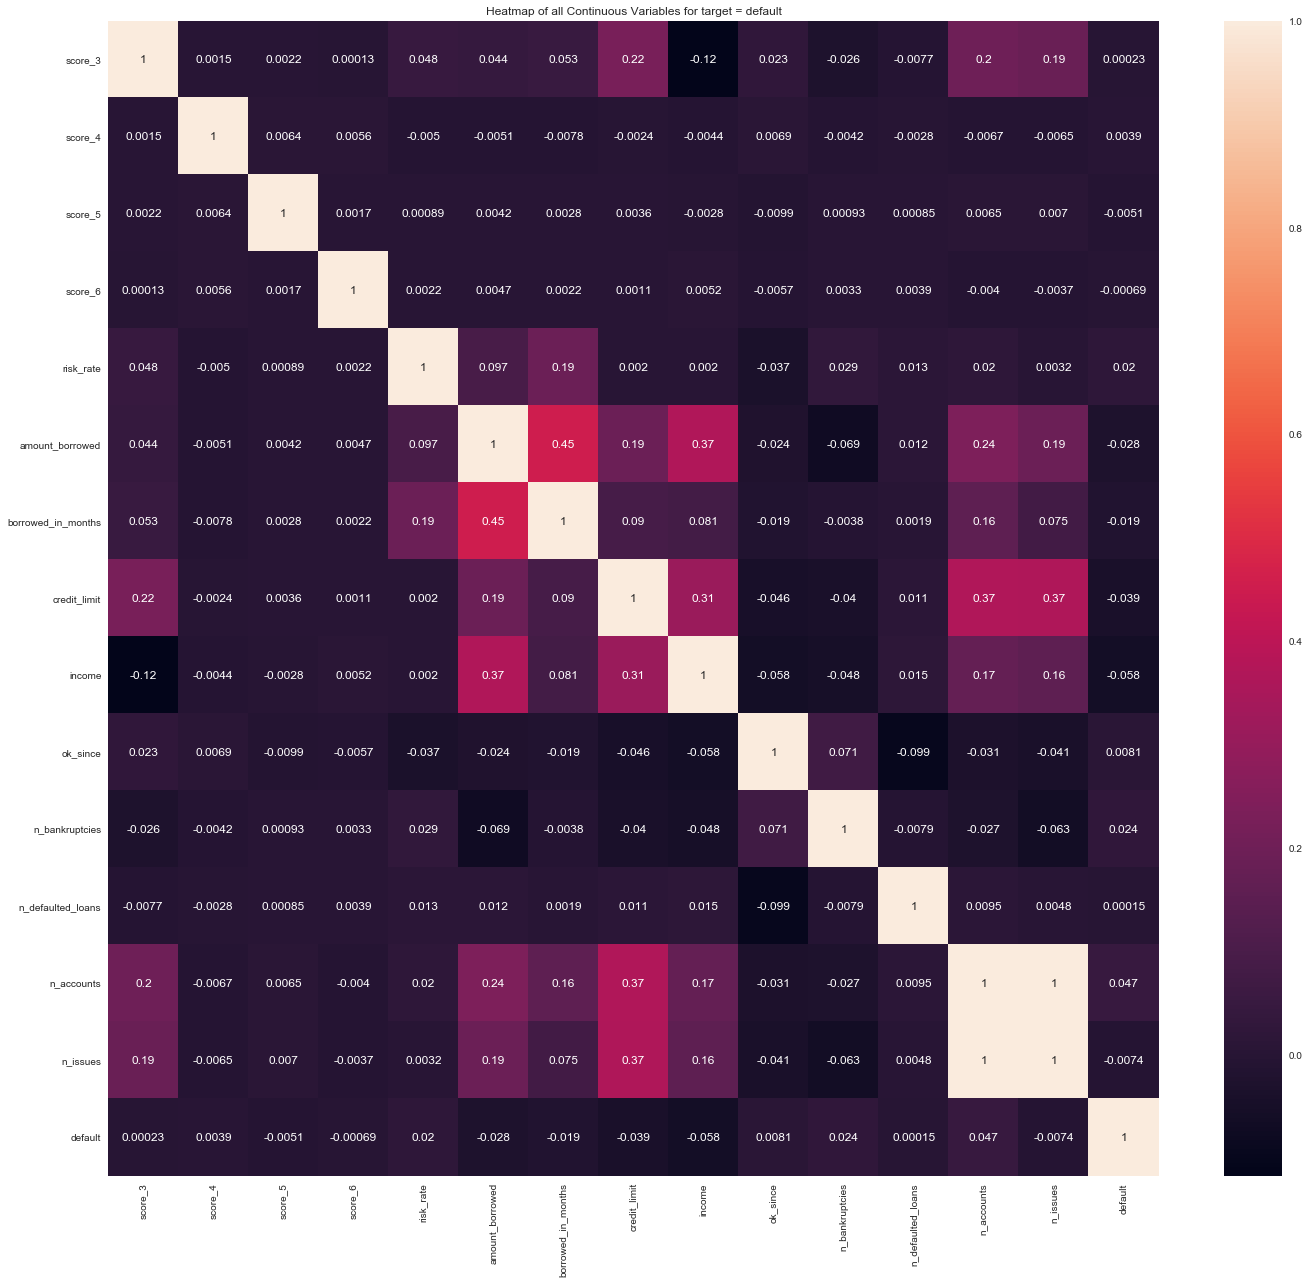

Number of Cat and Continuous Vars exceeds 30, hence no Pivot or Bar Charts
Time to run AutoViz (in seconds) = 85.006

 ###################### VISUALIZATION Completed ########################


In [24]:
def autoviz(df):
    from autoviz.AutoViz_Class import AutoViz_Class;
    AutoViz_Class().AutoViz(filename='',dfte=df, depVar='default', verbose=1);
        
autoviz(df)

Outra nova ferramenta de visualização automática e consideravelmente mais completa para analise de um dataframe é o *pandas_profiling*. Esta apresenta praticamente todos os graficos e analises iniciais de um DataFrame.

Vamos utiliza-lo

In [87]:
def pandas_profiling(df, jupyter):
    from pandas_profiling import ProfileReport;
    from IPython.display import clear_output
    profile = ProfileReport(df, title = "Dados de inadimplência - HBSIS", html = {"style": {"full_width": True}});
    clear_output(wait=True)
    if jupyter:
        profile.to_notebook_iframe();
    else:
        profile.to_widgets()
        
pandas_profiling(df, jupyter=False);

Com estes plots, percebemos que:
* Nenhuma das variavés, **individualmente**, possui (visualmente) forte relação com o TARGET('default')
* Existência de variaveis quantitativas(numéricas) e qualitativas(categóricas). Algumas com dificuldades conhecidas.

## Analisando as variáveis
#### Quanto ao seu tipo

Para entendermos melhor as variáveis, vamos construir manualmente, para apoio, um dataframe descritivo.

In [2]:
# Separa entre int, float, bool e strings (object)  
# forçando a identificação do tipo de variavel (já que 'df.dtype' não identificou int64 e bool)
def describe_gabriel(df):
    def dtypes_gabriel(df):
        col={}
        for coluna in df.columns:
            try:
                if df[f'{coluna}'].fillna(0).apply(float.is_integer).all():
                    col.update({coluna:'int64'})
                else:
                    col.update({coluna:'float64'})
            except:
                if (df[f'{coluna}'].any() == True) or (df[f'{coluna}'].nunique() ==2):
                    col.update({coluna:'bool'})

                else:
                    col.update({coluna:'object'})
        return pd.DataFrame.from_dict(col, orient='index')

    # permite visualizar todas as FEACTURES
    pd.set_option('display.max_rows', 30)

    # cria DataFrame de descrição
    temp = df.describe(include='all').transpose()
    desc = temp.filter('')
    # tipo
    desc['type']=dtypes_gabriel(df)
    # Numero (e proporção) de NaNs
    desc['NaN']=df.shape[0]-temp['count']
    desc['NaN(%)']=(100*(desc['NaN']/df.shape[0])).apply(int)
    desc['NaN']=desc['NaN'].apply(str) + '('+ desc['NaN(%)'].apply(str) +'%)'
    desc[temp.columns]=temp[temp.columns]
    desc = desc.drop(columns='NaN(%)')
    desc.update(df[desc[desc['type']=='int64'].index].astype('object').describe().transpose())
    return desc, temp

desc, tempdf = describe_gabriel(df)
desc

type           NaN  count unique                  top  \
ids                  object         0(0%)  64592  64592  2c2e4fb5-a75c-61...   
default                bool      4626(7%)  59966      2                False   
score_1              object       785(1%)  63807      7  DGCQep2AE5QRkNCs...   
score_2              object       785(1%)  63807     35  osCzpM4hJrxugqWW...   
score_3               int64     785.0(1%)  63807     88                  330   
score_4             float64       0.0(0%)  64592    NaN                  NaN   
score_5             float64       0.0(0%)  64592    NaN                  NaN   
score_6             float64       0.0(0%)  64592    NaN                  NaN   
risk_rate           float64     785.0(1%)  63807    NaN                  NaN   
amount_borrowed     float64     785.0(1%)  63807    NaN                  NaN   
borrowed_in_months    int64     785.0(1%)  63807      2                   36   
credit_limit          int64  19753.0(30%)  44839  28259                    0   
reason               object       791(1%)  63801  20345  mLVIVxoGY7TUDJ1F...   
income              float64     785.0(1%)  63807    NaN                  NaN   
sign                 object    20767(32%)  43825     12                 libr   
gender                 bool     7186(11%)  57406      2                    m   
facebook_profile       bool      6407(9%)  58185      2                False   
state                object       785(1%)  63807     50  xsd3ZdsI3356I3xM...   
zip                  object       785(1%)  63807    830  3k2JCQ8Bp5oDwaI3...   
channel              object       785(1%)  63807      1  NCqL3QBx0pscDnx3...   
job_name             object      4795(7%)  59797  44604  mLVIVxoGY7TUDJ1F...   
real_state           object       785(1%)  63807      5  N5/CE7lSkAfB04hV...   
ok_since              int64  38038.0(58%)  26554    104                    8   
n_bankruptcies        int64     987.0(1%)  63605      7                    0   
n_defaulted_loans     int64     803.0(1%)  63789      5                    0   
n_accounts            int64     785.0(1%)  63807     45                    9   
n_issues              int64  16451.0(25%)  48141     45                    9   

                     freq        mean        std          min       25%  \
ids                     1         NaN        NaN          NaN       NaN   
default             50456         NaN        NaN          NaN       NaN   
score_1             21029         NaN        NaN          NaN       NaN   
score_2              5202         NaN        NaN          NaN       NaN   
score_3              2357     348.032    110.065            0       270   
score_4               NaN     99.9979    3.17087      86.1916   97.8587   
score_5               NaN     0.49922   0.288769  3.54358e-05  0.250295   
score_6               NaN     99.9427    10.0342       60.663   93.2103   
risk_rate             NaN    0.296404   0.101549            0      0.22   
amount_borrowed       NaN     13853.3    8105.66       527.07   7762.94   
borrowed_in_months  48293     41.8353    10.2956           36        36   
credit_limit         7548       34562    37041.9            0     10000   
reason               6510         NaN        NaN          NaN       NaN   
income                NaN     71809.7    51249.9      4821.18   45013.4   
sign                 5810         NaN        NaN          NaN       NaN   
gender              38894         NaN        NaN          NaN       NaN   
facebook_profile    35824         NaN        NaN          NaN       NaN   
state               10656         NaN        NaN          NaN       NaN   
zip                   813         NaN        NaN          NaN       NaN   
channel             63807         NaN        NaN          NaN       NaN   
job_name              244         NaN        NaN          NaN       NaN   
real_state          32105         NaN        NaN          NaN       NaN   
ok_since              541     35.1742    21.6637         

#### Variaveis com numeros inteiros merecem atenção
Elas podem ser:
* Índices de classes/categoria (transformada de uma variavel categórica).
* Discreta
* Contínuas, mas com uma resolução limitada (sem decimais), como a 'credit_limit'. A medida que essa resolução diminui, a variavel perde continuidade e passa a se tornar discreta.

Abaixo uma imagem para relembrar os principais tipos de variáveis:

![title](media/variaveis.jpg)

Entender a natureza da variável é crucial para a definição do(s) algoritmo(s) a ser(em) testado(s) e, posteriormente como estas variaveis serão inseridas nele(s). Seguidamente, entendendo melhor as variaveis, pode-se decidir sobre exclusão de variaveis, redução de dimensionalidade (em alguns casos), utilização de modelos empilhados (catedoricos+regressivos, por exemplo), etc.

Vamos eliminar as colunas inúteis e separar as restantes entre numéricas e categóricas (+ booleanas):

In [3]:
# drop irrelevantes
drop = [
    'ids',     # o número de valores unicos é igual ao total.
    'channel', # é constante em todo o Dataset.
]    

df.drop(columns=drop, inplace=True)
desc.drop(drop, inplace=True)

No caso de se buscar buscar redução de custos, algumas variaveis com alta cardinalidade(job_name, reason ,zip), ou grande quantidade de NaNs (credit_limit, n_issues, ok_since) ou extremamente desbalanceadas poderiam ser eliminadas, **mas vamos mante-las na esperança de uma pequena melhora**.

####  Algumas observações:

numerics:
* **borrowed_in_months** possui forte correlação linear com 'default'. Podemos considera-la como numérica contínua (ou ordinal). Ou categorica tbm. (valores: 36 e 60)
* **credit_limit** apesar de inteiros, pode ser tratada como *variavel contínua* (float)
* **n_bankruptcies**,      # falêcias (Variavel com poucos casos, especialmentes >=2)
* **n_defaulted_loans**,   # emprestimos inadimplentes (poquissimos casos(0,4%). Esta variavel será provavelmente ignorada pelos modelos)

#### possiveis a dropar:

Numerics:
* **n_bankruptcies** e **n_defaulted_loans** são numericas e possuem poucos casos não nulos. Aparentemente são pouco impactantes. 

Nominais:
* **reason** e **job_name**   altíssima cardinálidade (20345 classes em 63807 valores)








In [4]:
def separa(tipo):
    return list(desc[desc.type==tipo].index)



continuas = separa('float64')
ordinais = separa('int64')
nominais = separa('object')+separa('bool')    # vamos colocar os booleanos juntos para aplicarmos OHE usando 'is_NaN' como uma categoria (totalizando 3 cat e deixando de ser bool)
nominais.remove('default')  # menos o 'default', que continuará bool
alvo = ['default']

# visualizar
pd.DataFrame.from_dict({'continuas':continuas, 'ordinais':ordinais, 'nominais':nominais, 'alvo':alvo}, orient='index').T.astype(object).replace({None: ''})

continuas            ordinais          nominais     alvo
0          score_4             score_3           score_1  default
1          score_5  borrowed_in_months           score_2         
2          score_6        credit_limit            reason         
3        risk_rate            ok_since              sign         
4  amount_borrowed      n_bankruptcies             state         
5           income   n_defaulted_loans               zip         
6                           n_accounts          job_name         
7                             n_issues        real_state         
8                                                 gender         
9                                       facebook_profile

#### Quanto aos valores NaNs
O dataset possui valores ausentes. Visualizar a distribuição pode gerar insights. O grafico a seguir mostra a completitude das séries e, como ultima "barra", a completitude total das linhas.

C:\Users\gabriel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dataset completo


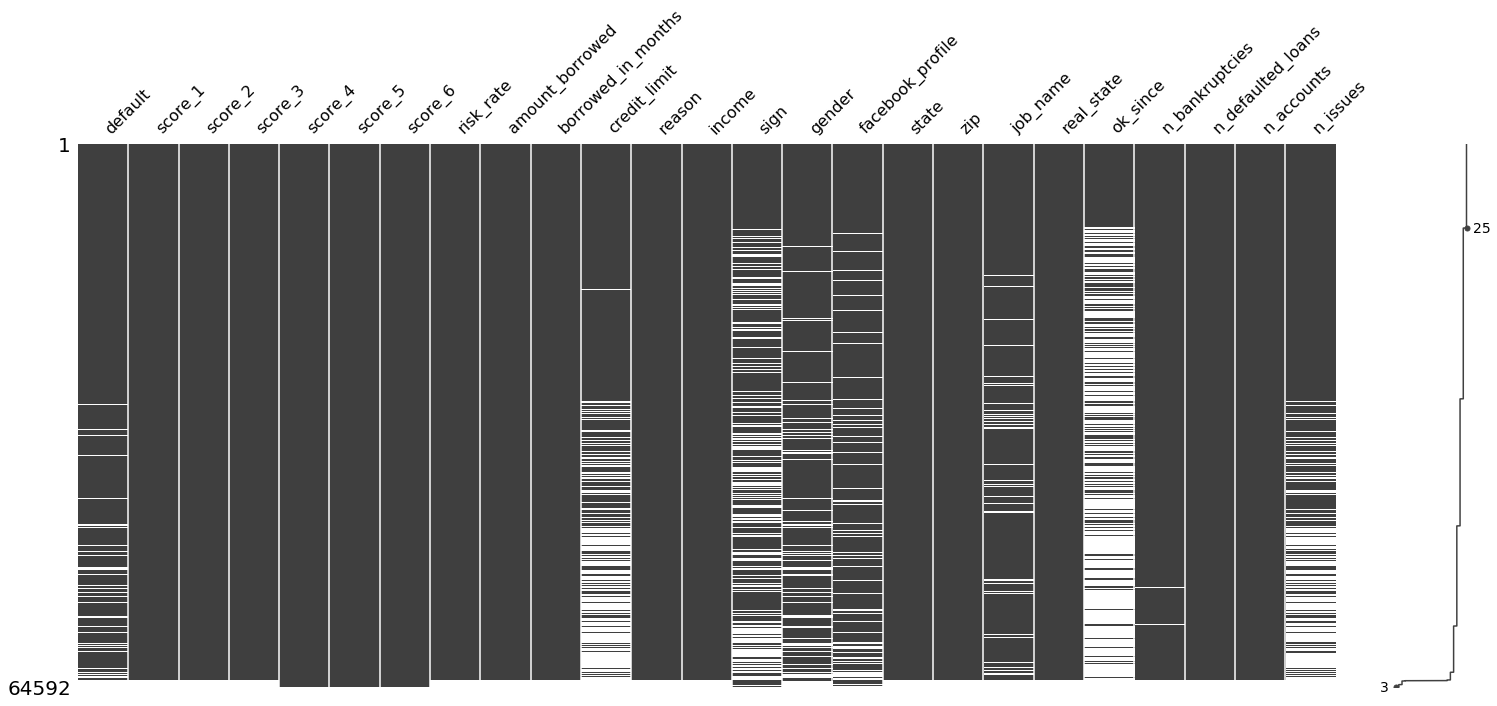

In [5]:
import missingno as msno
print('Dataset completo')
msno.matrix(df, sort='descending');

A coluna alvo ('default') tem valores NaN. Pode-se:
* treinar um modelo para preencher esses valores e então treina-lo novamente com o conjunto completo.
* simplesmente ignora-los, dropando-os.

De qualquer forma precisamos trabalhar inicialmente apenas com linhas contendo alvo


 Dataset descartando linhas sem alvo (cerca de 7.16 %)


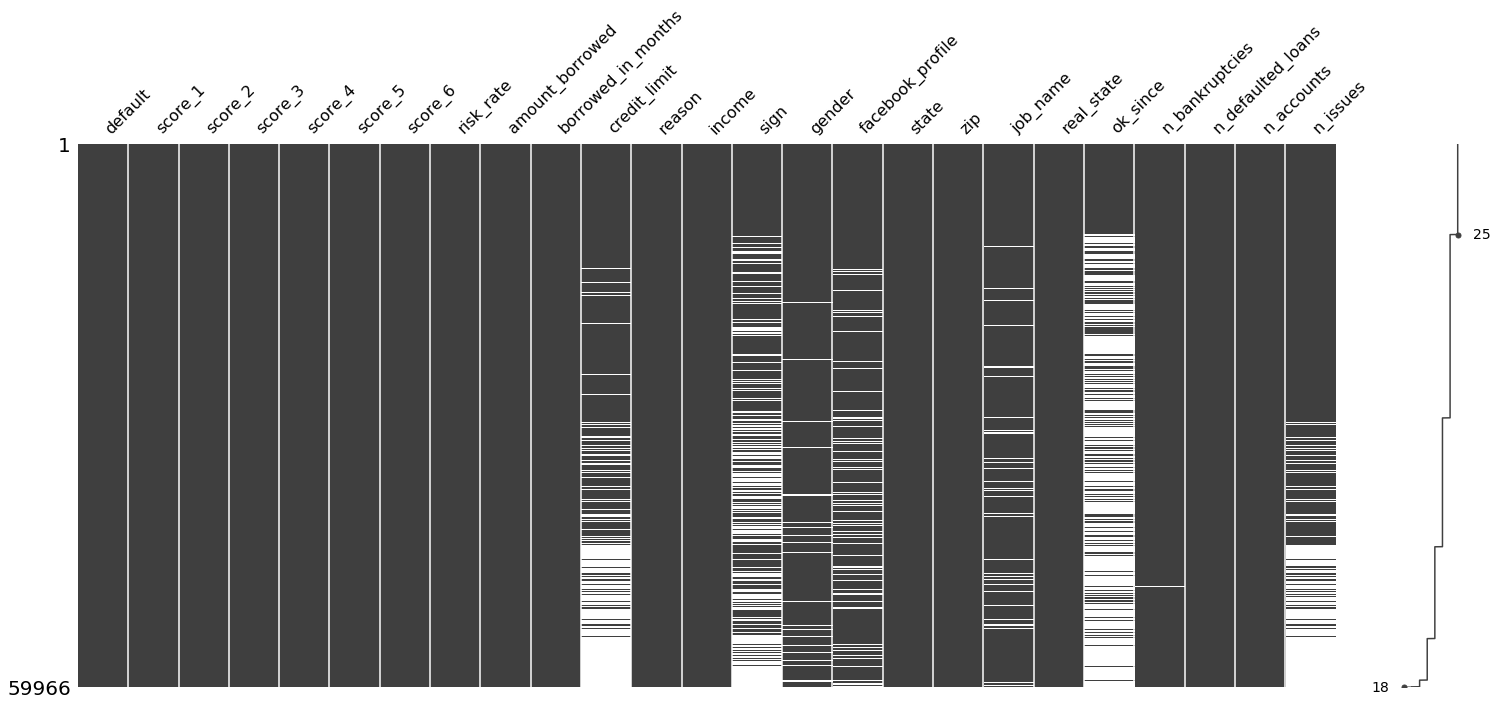

In [6]:
df2=df.dropna(subset=['default']).copy()

print('\n Dataset descartando linhas sem alvo (cerca de',df['default'].isna().mean().round(4) * 100,'%)')
msno.matrix(df2, sort='descending');

Observamos, na extrema direita, que na melhor das hipóteses teremos todas as features(**25**).
Com a eliminação dos dados sem alvo, almentaram de **3** para **18** o numero mínimo de características por amostra.
Vamos dropar linhas em que colunas possuem raros NaNs:

In [7]:
for coluna in df2.columns:
    if 0<df2[coluna].isna().mean()<0.01:
        df2.dropna(inplace=True, subset=[coluna])
        print(coluna)

reason
n_bankruptcies


Observamos variaveis, como 'credit_limit', 'sign' , 'ok_since' e 'n_insues' com grande quantidade de vazios. 

Uma possivel análise seria verificar se a falta dado é ocasional ou existe importancia nesta falta (*a falta em si é uma informação relevante?*)
Vamos ver se há correlação entre a falta de dados e o resultado de inadimplência:

C:\Users\gabriel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Atentar à primeira coluna (default)


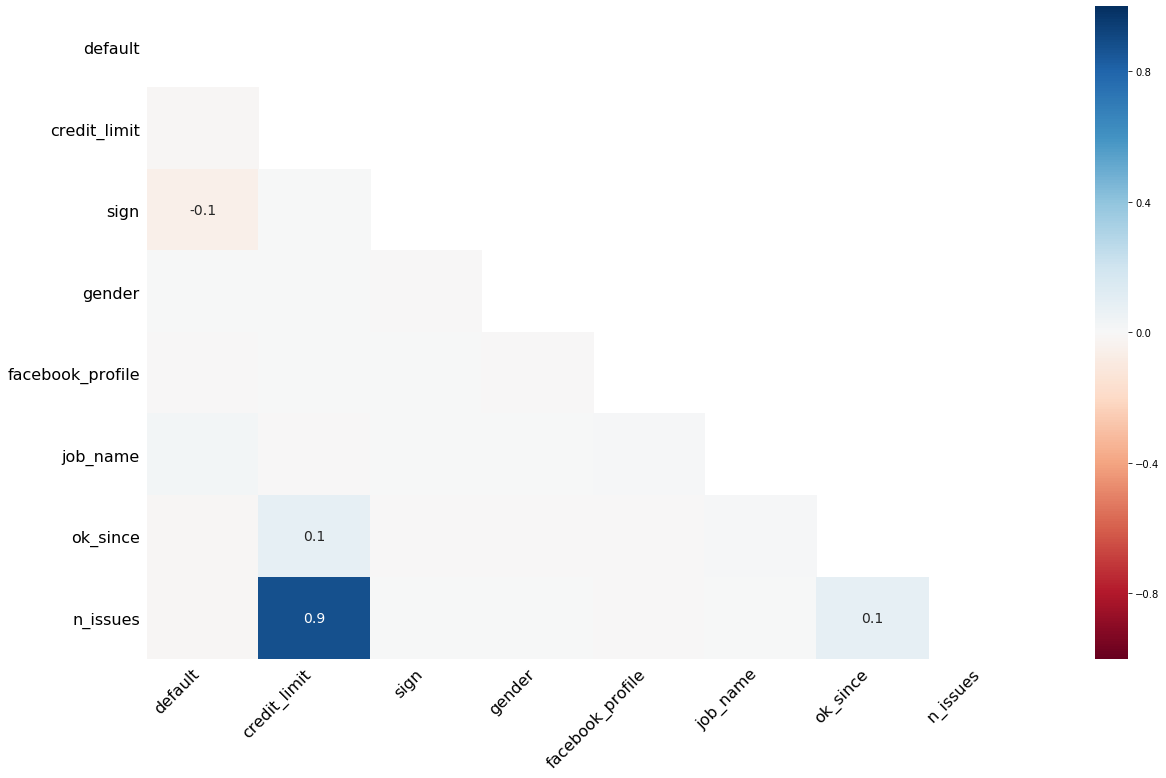

In [8]:
# correlação entre vazios
temp = df2.copy();
temp['default'][temp['default']]=np.nan
msno.heatmap(temp)
print('Atentar à primeira coluna (default)')

Opa. há um viés nos dados de *signos*... Vamos plotar a distribuição 

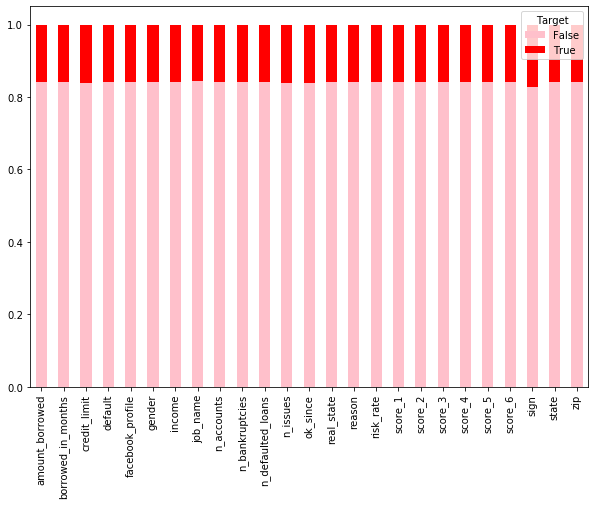

In [9]:
temp = df2.copy()
temp['Target']=temp['default'].copy().fillna('nan')
dff = temp.groupby(['Target']).count()
dff['x']=0
dff2=(dff.groupby(['x']).sum())
dff2=dff2.append(dff.groupby(['x']).sum())
dff2.index = dff.index
dff3 = dff/dff2
dff3.drop(columns='x', inplace=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
dff3
dff3.transpose().plot.bar(stacked=True, figsize=(10,7), log=False, color=['pink', 'red']);

Em relação ao alvo ('default'), 'sign' está desbalanceado, mas bem pouco. A influencia nos resultados deve ser infima.
Neste exemplo, significa que, se houver valor de signo valido, existe um ligeiro aumento na probabilidade de inadimplencia.

O dataset está desequilibrado. Há mais de 5 adimplentes para cada inadimplente.
Para lidarem com dados desbalanceados modelos como xgboost ou Decision tree oferecem parâmetros:
* 'is_unbalance'
* 'scale_pos_weight' 

Em pesquisa, a comunidade tem observado resultados melhores com o uso 'manual' do segundo argumento. Vamos guarda-lo para mais tarde.

In [10]:
scale_pos_weight = (dff3['default'][0] / dff3['default'][1]).round(1)
scale_pos_weight

5.3

Falando em correlação, estas duas variaveis chamaram a atenção. Vamos visualiza-las com dispersão:

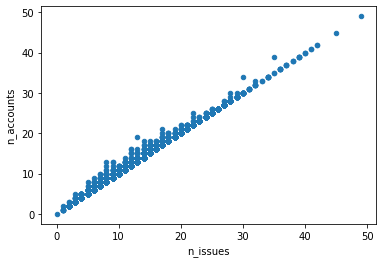

In [11]:
df2.plot.scatter(x='n_issues',y='n_accounts');

Muito alta a correlação. Relembrando:
* Para modelos lineares (por exemplo, regressão linear ou regressão logística), a multicolinearidade pode gerar maior variância (possivelmente instáveis numericamente).
* Florestas aleatórias podem usar apenas uma das variaveis, perdendo então as particularidades que as diferenciam.

Ao invés de simplesmente dropa-la (dropar também é uma opção), podemos aproveita-la substituindo-a pela sua diferença(ou proporção).
Quando analizamos a relação, vemos que não há um aumento proporcional de variância(a diferença não é proporcional ao crescimento)
Desta forma, melhor usar a diferença que a proporção.

In [12]:
df2['n_issues']=df2['n_accounts']-df2['n_issues']

### Preparando frames de treinamento e teste

Para terminar de resolver o problema dos NaNs nas variaveis categoricas, sem dropa-los, vamos aponta-los criando uma nova categoria

In [13]:
# Vamos criar a categoria 'is_NAN' nas colunas
df2[nominais]=df2[nominais].fillna('is_NAN')

df2[continuas + nominais + alvo].isnull().sum().sum()

0

Para lidar com as variáveis com grande cardinalidade, vamos transforma-las em variaveis numéricas que representam sua frequência

In [14]:
for coluna in ['reason', 'zip', 'job_name']:
    freq = df2[coluna].value_counts().to_dict()
    df2[coluna] = df2[coluna].map(freq)  # replace demora muuuito
    nominais.remove(coluna)
    ordinais.append(coluna)
pd.DataFrame.from_dict({'continuas':continuas, 'ordinais':ordinais, 'nominais':nominais, 'alvo':alvo}, orient='index').T.astype(object).replace({None: ''})

continuas            ordinais          nominais     alvo
0           score_4             score_3           score_1  default
1           score_5  borrowed_in_months           score_2         
2           score_6        credit_limit              sign         
3         risk_rate            ok_since             state         
4   amount_borrowed      n_bankruptcies        real_state         
5            income   n_defaulted_loans            gender         
6                            n_accounts  facebook_profile         
7                              n_issues                           
8                                reason                           
9                                   zip                           
10                             job_name

Mais alguns ajustes pontuais

In [15]:
#transforma em bin
df2['borrowed_in_months'] = ((df2['borrowed_in_months']-36)/24)
df2[alvo] = df2[alvo].astype('int')
#libera nans para tratamento numérico
df2['job_name']=df2['job_name'].replace(freq['is_NAN'], np.nan) # Para que seja preenchido no passo seguinte

Temos que preencher (ou dropar) as linhas com NaNs e transformar as features 
Escolher entre 3 opções:

In [16]:
#####  1. drop
#df2=df2.dropna()
#####  2. fill -1
df2[ordinais]=df2[ordinais].fillna(-1)
#####  2. fill média (ou mediana)
#for coluna in df2.columns:
#    df2[coluna].fillna(df2[coluna].mean, inplace=True)
#    df2[coluna].fillna(df2[coluna].median, inplace=True)
df2[ordinais]=df2[ordinais].astype(int)
    
#################################################
print('Há',df2.isnull().sum().sum(), 'NaNs')

Há 0 NaNs


Podemos futurament testar qual a melhor (média, mediana, regressão, etc)

Por fim, vamos transformar as variaveis nominais em numéricas usando *dummies*

In [ ]:
# Usando dummies
df_geral = pd.get_dummies(df2, columns=nominais).copy()

# usando apenas frequencia
df_no_dummies = df2.copy()
for coluna in nominais:
    freq = df_no_dummies[coluna].value_counts().to_dict()
    df_no_dummies[coluna] = df_no_dummies[coluna].map(freq)
df_no_dummies

## Treinamento
### Modelo preliminar

Para retornar a importancia individual das variaveis, vamos experimentar extrair utilizando apenas transformação de frequencia paa todas as variaveis nominais, deixando dummies (ou OHE) para a proxima etapa.

In [81]:
def splitby_df(df):
    y = df['default']
    x = df.drop(columns='default')
    from sklearn.model_selection import train_test_split
    return train_test_split(x, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test =splitby_df(df_no_dummies)

Vamos treinar uma modelo Random Forest para termos uma primeira impressão das variaveis mais importantes e de um primeiro índicador de desempenho a se tentar superar.
* Levando em consideração se tratar de um classificador com alvo binário desbalanceado, a melhor estratégia deavaliação é usar AUC ROC (àrea sob a curva ROC).

AUC:    0.75708 (rfi)


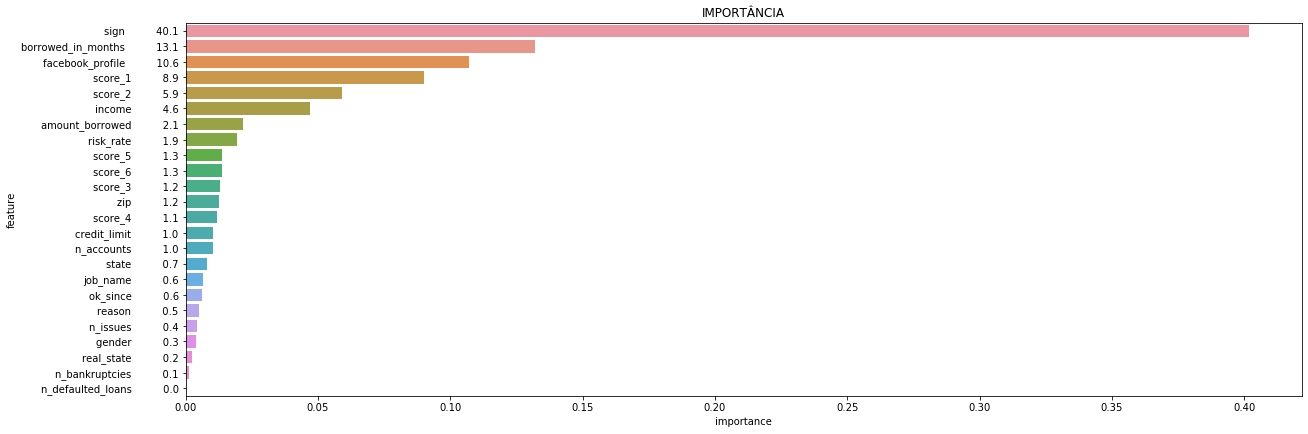

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rfi = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=27, max_features=10, oob_score=True)
rfi.fit(X_train, y_train)

def print_auc(model, name):
    print(f"AUC:    %2.5f ({name})" % (roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))


def get_feature_importance_df(feature_importances, column_names, n_feactures=None):
    """Feature importances computed by an ensemble model like random forest or boosting"""
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:n_feactures]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    fi = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    ########################
    import seaborn as sns;
    fig,ax = plt.subplots();
    fig.set_size_inches(20,fi.shape[0]/3.5);
    ax.set(xlabel='Variable name', ylabel='Importance',title="IMPORTÂNCIA");
    fi['feature'] = fi['feature']+'          '+ ((1000*fi['importance']).astype(int).astype(float)/10).round(4).astype(str);
    x = sns.barplot(data=fi[:n_feactures],y="feature",x="importance",ax=ax, orient='h');
    #return fi
    return x

print_auc(rfi, 'rfi')
get_feature_importance_df(rfi.feature_importances_,  X_train.columns.values);

Uma representação de uma arvore (demonstrando decisões por 4 features)
![](media/decision-tree-4.png)

## Modelo final

Em testes, verificamos superioridade do método dummies frente à transformação em frequência. Prosigamos com ele.

In [83]:
X_train, X_test, y_train, y_test = splitby_df(df_geral)

In [84]:
# LightGBM (microsoft)
import lightgbm as lgb

params = {
    'objective':'binary',
    'boosting_type': 'gbdt',
    'metric': {'auc'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': 0,
    'scale_pos_weight':scale_pos_weight,   #usando o peso para balancear (utilizando, obteve levíssima melhora)
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test,
                early_stopping_rounds=100,
            )
from IPython.display import clear_output
clear_output(wait=True)

lgbm_score = roc_auc_score(y_test, lgbm.predict(X_test, num_iteration=lgbm.best_iteration))
print(f"AUC:    %2.5f ({'lgbm'})" % (lgbm_score))

AUC:    0.76879 (lgbm)


In [75]:
# boosts
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# RandomForest
rf = RandomForestClassifier(n_estimators=75, max_depth=9, random_state=27, max_features=10, oob_score=True) # mesmo anterior

# GradientBoosting
gb_params = {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1}
gb = GradientBoostingClassifier(**gb_params)

# AdaBoost
ab_params = {'learning_rate': 0.3, 'n_estimators': 150}
ab = AdaBoostClassifier(**ab_params)

# XGBoost
xgb_params = {'colsample_bytree': 0.9, 'learning_rate': 0.05,  'min_child_weight': 7, \
                      'n_estimators': 200, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 57, 'silent': 1, \
                      'subsample': 0.7, 'base_score': 0.8,'gamma': 0.1, 'max_depth': 3, 'min_samples_leaf': 2}
xgb = XGBClassifier(**xgb_params)

# Ajuste por CV
for clf, modelo in zip([rf, gb, ab, xgb], ['rf', 'gb', 'ad', 'xgb']):
    scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='roc_auc')
    print(f"AUC:    %2.5f ({modelo})" % (scores.mean()))

AUC:    0.76080 (rf)
AUC:    0.76875 (gb)
AUC:    0.77081 (ad)
AUC:    0.76988 (xgb)


In [85]:
# Aplicando modelos ao teste (validando)

# Cria log
names =  []
aucs = []

# Adiciona o lightGBM
names.append('lgb')
aucs.append(lgbm_score)
print(f"AUC:    %2.5f ({'lgb'})" % (lgbm_score))

# Adiciona os por sklearn
for name, model in [('rf', rf),('gb',gb),  ('ab', ab),  ('xgb',xgb)]:
    model.fit(X_train, y_train)
    names.append(name)
    aucs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print_auc(model, name)

AUC:    0.76879 (lgb)
AUC:    0.75991 (rf)
AUC:    0.77021 (gb)
AUC:    0.77389 (ab)
AUC:    0.77095 (xgb)


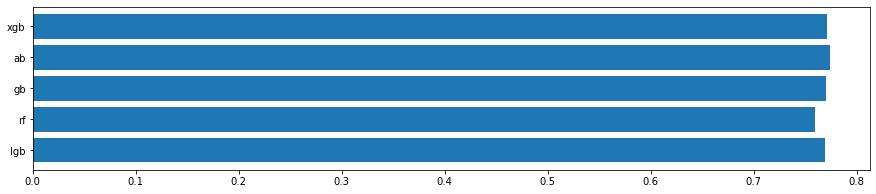

In [86]:
plt.figure(figsize=(15,3))
plt.barh(names, aucs);

Em uma proxima etapa poderiamos criar assembles entre os métodos, usar o gridsearchCV para buscar todos os melhores parametros e até tentar trabalhar com os valores que foram dropados treinando novamente, posteriormente, os modelos.

*Vamos salvar o melhor modelo (AdaBoost) e plotar a ROC*

In [ ]:
model = ab
#salva modelo
filename = 'modelo_final.sav'

import joblib
joblib.dump(model, filename)

In [67]:
#carregar modelo:
filename = 'modelo_final.sav'

import joblib
loaded_model = joblib.load(filename)
print_auc(loaded_model, 'loaded_model')

AUC ROC:   0.7738941391359594
AUC:    0.77389 (loaded_model)


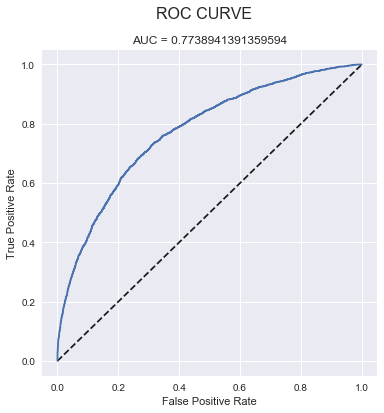

In [51]:
def roc_plot(y_test, y_pred):
    from sklearn import metrics
    import numpy as np
    import matplotlib.pyplot as plt
    #y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.suptitle('ROC CURVE',fontsize=16)
    plt.title(f'AUC = {np.trapz(tpr,fpr)}')
    return plt.show()

roc_plot(y_test, loaded_model.predict_proba(X_test)[:,1])

.

.

.

.

## Modelagem com AutoML

Pelo número e variabilidade dos recursos, para obter resultados maximos em acurácia, um longo percurso foi percorrido. 
Isto inclui exploração de dados, pré-processamento de dados, engenharia de recursos, seleção de modelos, treinamento, avaliação, etc.

Esta seção demonstra o uso do H2O AutoML e google AutoML para reduzir a quantidade de trabalho manual, incluindo mas não se limitando ao seguinte:
* pré-processamento automático de dados (tratamento de dados ausentes, por exemplo)
* engenharia automática de recursos
* seleção automática de modelo
* treinamento e ajustes automáticos
* avaliação automática do modelo

A utilização de ferramentas automáticas potencializam e aceleram a produção, mas não substitui o especialista.

Segue [aqui](/AutoML-auc-0-773.md) um aplicação de AutoML para este puzzle.

**Este foi o resultado:**

![](media/97a4d4a813417f62f09e791fe93198d1.png)

# Conclusão
* Os melhores resultados contam com ROC AUC em cerca de 0.773
* Um perfil de signo sagitário, que possui perfil de facebook e empréstimo para 60 meses possui alto risco de inadimplência.
